In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os
import numpy as np
from poisson_numcodecs.Poisson import Poisson
from poisson_numcodecs import estimate
import zarr

In [2]:
data = np.load('../tests/data/data1.npz')['data']

In [3]:
# for bright images use count_weight_gamma=1
# for photon-starved images with few cells use count_weight_gamma = 0.001
# Otherwise, use the default

qs = estimate.compute_sensitivity(
    data.transpose(1,2,0),   # time must be in the third dimensions
    count_weight_gamma=1)  

In [4]:
qs

{'model': HuberRegressor(),
 'counts': array([605, 679, 675, ...,  27,  20,  26]),
 'min_intensity': 90,
 'max_intensity': 3016,
 'variance': array([  5706.29669421,   5897.68851252,   5368.22962963, ...,
        250302.94444444, 566103.325     , 584751.57692308]),
 'sensitivity': 96.99485239520567,
 'zero_level': 86.30213578612849}

Text(0, 0.5, 'variance')

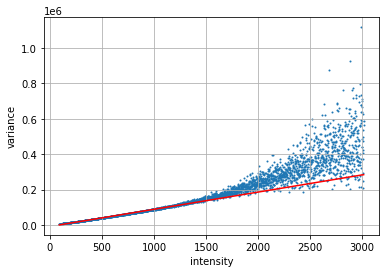

In [5]:
intensity = np.r_[qs['min_intensity']:qs['max_intensity']]
sensitivity = qs['sensitivity']
zero_level = qs['zero_level']
plt.scatter(intensity, qs['variance'], s=1)
plt.plot(intensity, (intensity - zero_level) * sensitivity, 'r')
plt.grid(True)
plt.xlabel('intensity')
plt.ylabel('variance')

In [8]:
# make compression lookup tables
zero = np.int16(np.round(qs['zero_level']))
LUT1 = estimate.make_anscombe_lookup(sensitivity)
LUT2 = estimate.make_inverse_lookup(LUT1)

In [10]:
# save compressed video as .gif
compressed = estimate.lookup(data - zero, LUT1)
gif_path = 'test.gif'
scale = 255//np.max(compressed)  # this makes the gif brighter. Use scale=1 normally
estimate.save_movie(compressed, gif_path, scale=scale)          
print(f'Compression ratio: {np.prod(data.shape)*2 / os.path.getsize(gif_path):0.2f}')

Compression ratio: 3.79


In [11]:
# instantiate Poisson object
poisson_filter = Poisson(zero_level, sensitivity)

In [13]:
# using default Zarr compressor
photon_data = zarr.array(data, filters=[poisson_filter])

In [14]:
data_read = photon_data[:]

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('S375000'), dtype('int64')) -> None